In [6]:
import os
import numpy as np
# from torch.utils.data import DataLoader, Dataset

from preprocess import resize_input, train_test_split
from triplet_dataset import TripletDataset

import cv2
import torch


In [7]:
import importlib
from triplet_dataset import TripletDataset
import triplet_dataset

importlib.reload(triplet_dataset)
from triplet_dataset import TripletDataset

In [8]:
# LIMIT = 80_000

In [9]:
train_dataset = torch.load("data/train_dataset_shuffled.pt")
len(train_dataset)

120809

In [10]:
# train_dataset = TripletDataset(train_dataset.data, train_dataset.labels)
# torch.save(train_dataset, "data/train_dataset.pt")

In [11]:
# Test
# (Xa, Xp, Xn), (ya, yp, yn) = eval_ds[0]


In [12]:
# Xa.shape, ya, Xp.shape, yp, Xn.shape, yn

In [13]:
# torch.save(eval_ds, "data/eval_dataset.pt")

In [14]:
# train_ds = TripletDataset(train_ds.data[:LIMIT], train_ds.labels[:LIMIT])

In [15]:
# torch.save(train_ds, "data/train_dataset_100k.pt")

In [16]:
# len(eval_ds), len(train_ds)

In [17]:
# from torch.utils.data import DataLoader

# dl = DataLoader(train_ds, 128, shuffle=True)

# for i, batch in enumerate(dl):
#     if i % 100 == 0:
#         print(i)

In [18]:
# torch.save(train_ds, "data/train_dataset.pt")
# torch.save(eval_ds, "data/eval_dataset.pt")


In [24]:
classes = np.array([i for i in range(1, 1311)])
train_subjects = np.loadtxt("../train_subjects_mask.txt")
tests = [i for i in range(1, 1311) if i not in train_subjects]

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [25]:
from PIL import Image
data_path = "../../UERC"

In [26]:
ear_data = os.listdir(data_path)

ear_imgs = {}
for person in ear_data:
    if int(person) not in train_subjects:
        continue
    
    imgs = os.listdir("%s/%s" % (data_path, person))
    try:
        ear_imgs[person] = [
            cv2.cvtColor(
                np.asarray(Image.open(f"{data_path}/{person}/{img}")), cv2.COLOR_BGR2RGB
            )
            for img in imgs
        ]
    except Exception as e:
        print(e)

In [27]:
# baseline_train = "../baseline/data/train_dataset.pt"
# baseline_eval = "../baseline/data/eval_dataset.pt"

In [28]:
# from ear_dataset import EarDataset

# baseline_train = torch.load(baseline_train)
# baseline_eval = torch.load(baseline_eval)

# X, y = [], []
# X.extend(baseline_train.data)
# y.extend(baseline_train.labels)

# X.extend(baseline_eval.data)
# y.extend(baseline_eval.labels)

# ear_imgs = {}
# for label in np.unique(y):  
#     ear_imgs[label] = []

# for d, label in zip(X, y):
#     ear_imgs[label].append(d)



In [29]:
X_train, X_eval, y_train, y_eval = train_test_split(ear_imgs)

In [30]:
# Get train set size
len(X_train) + len(X_eval)

173079

In [31]:
len(X_train)

120809

In [32]:
X_train = resize_input(X_train, 64, mode="train")

In [33]:
import importlib
from triplet_dataset import TripletDataset
import triplet_dataset

importlib.reload(triplet_dataset)
from triplet_dataset import TripletDataset


In [35]:
train_dataset = TripletDataset(X_train, y_train)

ValueError: a must be 1-dimensional

In [ ]:
(Xa, Xp, Xn), (ya, yp, yn) = train_dataset[3]

In [ ]:
Xa.shape, Xp.shape, Xn.shape, ya, yp, yn

(torch.Size([3, 64, 64]),
 torch.Size([3, 64, 64]),
 torch.Size([3, 64, 64]),
 914,
 914,
 42)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


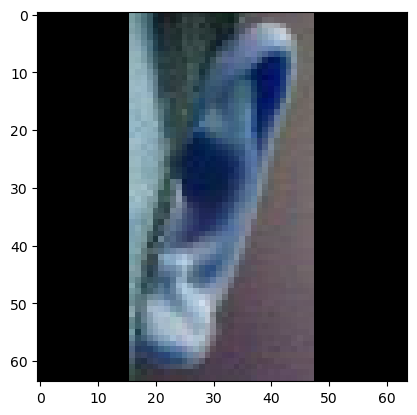

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(Xa.permute(1,2,0))

In [ ]:
torch.save(train_dataset, "data/train_dataset_shuffled.pt")

In [ ]:
X_eval = resize_input(X_eval, 64, mode="test")

eval_dataset = TripletDataset(X_eval, y_eval)

In [ ]:
from torch.utils.data import DataLoader

dl = DataLoader(eval_dataset, 1, shuffle=True)

In [ ]:
sample = next(iter(dl))

In [ ]:
data, label = sample

Xa, Xp, Xn = data
ya, yp, yn = label

Xa.shape

torch.Size([1, 3, 64, 64])

In [ ]:
torch.save(eval_dataset, "data/eval_dataset_shuffled.pt")
